Les BDD utiles : 
client.query_activated_balancing_energy(...)
 -> client.query_activated_balancing_energy_prices(...)
 -> client.query_aggregate_water_reservoirs_and_hydro_storage(...)
 -> client.query_aggregated_bids(...)
 -> client.query_contracted_reserve_amount(...)
 -> client.query_contracted_reserve_prices(...)
 -> client.query_contracted_reserve_prices_procured_capacity(...)
 -> client.query_crossborder_flows(...)
 -> client.query_current_balancing_state(...)
 -> client.query_day_ahead_prices(...)
 -> client.query_day_ahead_prices_local(...)
 -> client.query_generation(...)
 -> client.query_generation_forecast(...)
 -> client.query_generation_import(...)
 -> client.query_generation_per_plant(...)
 -> client.query_imbalance_prices(...)
 -> client.query_imbalance_volumes(...)
 -> client.query_import(...)
 -> client.query_installed_generation_capacity(...)
 -> client.query_installed_generation_capacity_per_unit(...)
 -> client.query_intraday_offered_capacity(...)
 -> client.query_intraday_prices(...)
 -> client.query_intraday_wind_and_solar_forecast(...)
 -> client.query_load(...)
 -> client.query_load_and_forecast(...)
 -> client.query_load_forecast(...)
 -> client.query_net_position(...)
 -> client.query_net_transfer_capacity_dayahead(...)
 -> client.query_net_transfer_capacity_monthahead(...)
 -> client.query_net_transfer_capacity_weekahead(...)
 -> client.query_net_transfer_capacity_yearahead(...)
 -> client.query_offered_capacity(...)
 -> client.query_physical_crossborder_allborders(...)
 -> client.query_procured_balancing_capacity(...)
 -> client.query_scheduled_exchanges(...)
 -> client.query_unavailability_of_generation_units(...)
 -> client.query_unavailability_of_offshore_grid(...)
 -> client.query_unavailability_of_production_units(...)
 -> client.query_unavailability_transmission(...)
 -> client.query_wind_and_solar_forecast(...)
 -> client.query_withdrawn_unavailability_of_generation_units(...)

Code de base pour préparer l'extract de données ENTSOE :

In [15]:
import pandas as pd
import numpy as np
from entsoe import EntsoePandasClient

API_KEY = '1efc1e14-c733-4915-bd4f-cf2e11e6750f'  
client = EntsoePandasClient(api_key=API_KEY)
country_code = 'FR'

start_date = pd.Timestamp('2023-01-01', tz='Europe/Paris')
end_date = pd.Timestamp('2024-01-01', tz='Europe/Paris')

📊 Taille initiale du Dataset : (8761, 3)

--- RAPPORT DE QUALITÉ ---
Load_Forecast     1
EnR_Forecast     25
Price             1
dtype: int64
📊 Taille finale après nettoyage : (8739, 3)


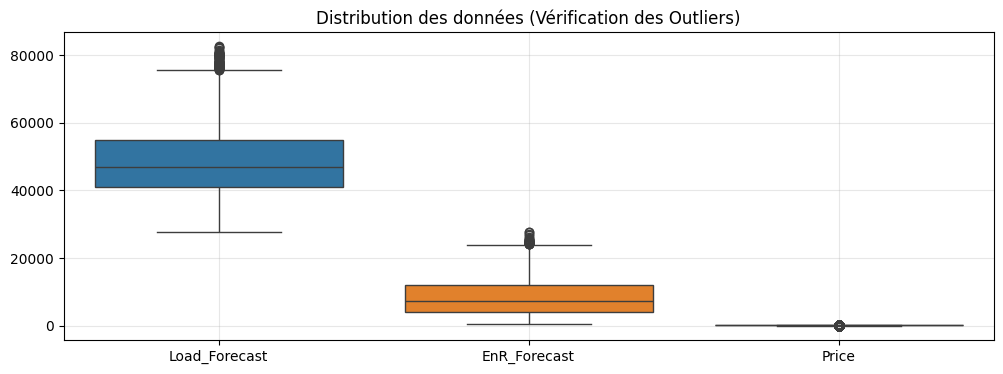

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# ==========================================
# 1. FUSION INTELLIGENTE (OUTER JOIN)
# ==========================================
# Charge (Conso)
load = client.query_load_forecast(country_code, start=start_date, end=end_date)


# EnR (Vent + Solaire)
Prev = client.query_wind_and_solar_forecast(country_code, start=start_date, end=end_date, psr_type=None)
Prev['EnR'] = Prev.sum(axis=1) # Somme de toutes les colonnes (Wind Onshore/Offshore + Solar)

# B. La Vérité Terrain (Pour la Vérification uniquement)
# On récupère les PRIX pour voir si l'algo a raison
prices = client.query_day_ahead_prices(country_code, start=start_date, end=end_date)
prices = prices.to_frame('Price')

# On concatène tout, mais on ne drop rien pour l'instant pour voir les trous
# axis=1 signifie qu'on aligne sur l'index (les dates)
df_raw = pd.concat([load, Prev['EnR'], prices], axis=1)

# On renomme proprement
df_raw.columns = ['Load_Forecast', 'EnR_Forecast', 'Price']

print(f"📊 Taille initiale du Dataset : {df_raw.shape}")

# Rapport textuel
missing_counts = df_raw.isnull().sum()
print("\n--- RAPPORT DE QUALITÉ ---")
print(missing_counts)


# ==========================================
# 3. TRAITEMENT DES DOUBLONS (DÉLICAT !)
# ==========================================
# Vérifier s'il y a des index dupliqués (Heure d'hiver ?)
df_raw.index.drop_duplicates()


# ==========================================
# 4. IMPUTATION (BOUCHAGE DES TROUS)
# ==========================================
# Pour une série temporelle, on ne drop pas brutalement.
# Si le trou est petit (ex: 1h), on "interpole" (on tire un trait entre l'heure d'avant et d'après).

# On interpole linéairement (limit=2 signifie qu'on ne bouche pas les trous > 2h, trop risqué)
df_clean = df_raw.interpolate(method='time', limit=2)

# S'il reste des trous au début ou à la fin, on peut drop
df_clean = df_clean.dropna()

print(f"📊 Taille finale après nettoyage : {df_clean.shape}")

# ==========================================
# 5. VISUALISATION DES ABERRATIONS (OUTLIERS)
# ==========================================
# Vérifier qu'on n'a pas de valeurs folles (ex: Conso négative)
plt.figure(figsize=(12, 4))
sns.boxplot(data=df_clean)
plt.title("Distribution des données (Vérification des Outliers)")
plt.grid(True, alpha=0.3)
plt.show()

# C'est CE dataframe propre que tu utilises pour la suite
df = df_clean.copy()

Isolation Forest pour la prédiction de prix négatifs à J-1


--- RÉSULTATS DU BACKTEST ---
Sur le jeu de test (données jamais vues) :
✅ Prix Négatifs correctement anticipés : 0
⚠️ Fausses Alarmes (Modèle dit 'Danger' mais prix positif) : 22
📉 Prix moyen lors des alertes : 66.80 €/MWh


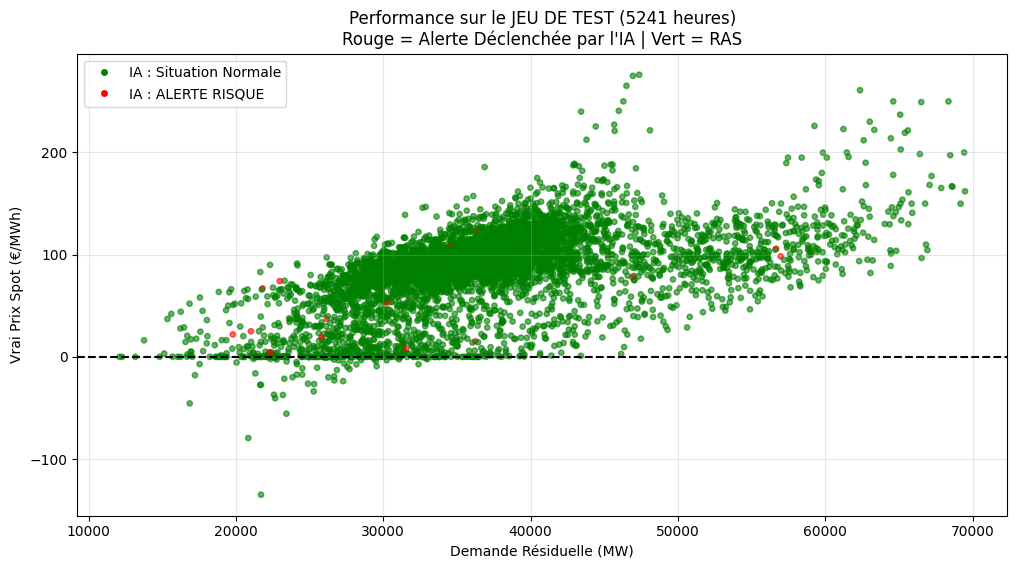

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from entsoe import EntsoePandasClient




# A. Les Fondamentaux (Pour le Modèle)
# Charge (Conso)
load = client.query_load_forecast(country_code, start=start_date, end=end_date)


# EnR (Vent + Solaire)
Prev = client.query_wind_and_solar_forecast(country_code, start=start_date, end=end_date, psr_type=None)
Prev['EnR'] = Prev.sum(axis=1) # Somme de toutes les colonnes (Wind Onshore/Offshore + Solar)

# B. La Vérité Terrain (Pour la Vérification uniquement)
# On récupère les PRIX pour voir si l'algo a raison
prices = client.query_day_ahead_prices(country_code, start=start_date, end=end_date)
prices = prices.to_frame('Price')

# Fusion
df = pd.concat([load, Prev['EnR'], prices], axis=1).dropna()


# Feature 1 : Demande Résiduelle (Le facteur principal)
df['Residual_Load'] = df['Forecasted Load'] - df['EnR']

# Feature 2 : Gradient (Vitesse de variation)
# Une chute brutale de la demande résiduelle est suspecte
df['Gradient'] = df['Residual_Load'].diff().fillna(0)

# Feature 3 : Heure de la journée (Cyclique)
# Les anomalies arrivent souvent à 14h (Solaire) ou la nuit (Vent)
df['Hour'] = df.index.hour

# ==========================================
# 3. TRAIN / TEST SPLIT (TEMPOREL)
# ==========================================
# On garde les 20% les plus récents pour le TEST
split_index = int(len(df) * 0.4)

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()


# Préparation des matrices X (Features)
features = ['Residual_Load', 'Gradient', 'Hour']
scaler = StandardScaler()

# On "fit" le scaler uniquement sur le train pour ne pas tricher
X_train = scaler.fit_transform(train_df[features])
X_test = scaler.transform(test_df[features]) # On applique la même transformation


# contamination=0.01 : On estime que 1% des heures sont "anormales" (Prix négatifs ou très bas)
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
model.fit(X_train)

# ==========================================
# 5. ÉVALUATION SUR LE TEST
# ==========================================
# Le modèle prédit : -1 (Anomalie) ou 1 (Normal)
test_df['Prediction_Code'] = model.predict(X_test)
test_df['Anomaly_Detected'] = test_df['Prediction_Code'] == -1

# DÉFINITION DE LA RÉALITÉ (GROUND TRUTH)
# On considère qu'un "Succès" est la détection d'un prix < 0 € (ou très bas, ex < 10€)
test_df['Real_Negative_Price'] = test_df['Price'] < 0

print("\n--- RÉSULTATS DU BACKTEST ---")
print("Sur le jeu de test (données jamais vues) :")

# On croise la prédiction avec la réalité
true_positives = test_df[(test_df['Anomaly_Detected'] == True) & (test_df['Real_Negative_Price'] == True)]
false_positives = test_df[(test_df['Anomaly_Detected'] == True) & (test_df['Real_Negative_Price'] == False)]

print(f"✅ Prix Négatifs correctement anticipés : {len(true_positives)}")
print(f"⚠️ Fausses Alarmes (Modèle dit 'Danger' mais prix positif) : {len(false_positives)}")

# Prix moyen quand le modèle crie "ALERTE"
avg_price_alert = test_df[test_df['Anomaly_Detected'] == True]['Price'].mean()
print(f"📉 Prix moyen lors des alertes : {avg_price_alert:.2f} €/MWh")

# ==========================================
# 6. VISUALISATION FINALE
# ==========================================
plt.figure(figsize=(12, 6))

# On affiche tout le Test Set
plt.scatter(test_df['Residual_Load'], test_df['Price'], 
            c=np.where(test_df['Anomaly_Detected'], 'red', 'green'), 
            alpha=0.6, s=15)

plt.axhline(0, color='black', linestyle='--')
plt.title(f"Performance sur le JEU DE TEST ({len(test_df)} heures)\nRouge = Alerte Déclenchée par l'IA | Vert = RAS")
plt.xlabel("Demande Résiduelle (MW)")
plt.ylabel("Vrai Prix Spot (€/MWh)")

# Légende manuelle
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='IA : Situation Normale'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='IA : ALERTE RISQUE')]
plt.legend(handles=legend_elements)

plt.grid(True, alpha=0.3)
plt.show()

Isolation Forest 2


--- RÉSULTATS DU BACKTEST ---
Sur le jeu de test (données jamais vues) :
Prix Négatifs correctement anticipés : 4
Fausses Alarmes (Modèle dit 'Danger' mais prix positif) : 90
Prix moyen lors des alertes : 65.80 €/MWh


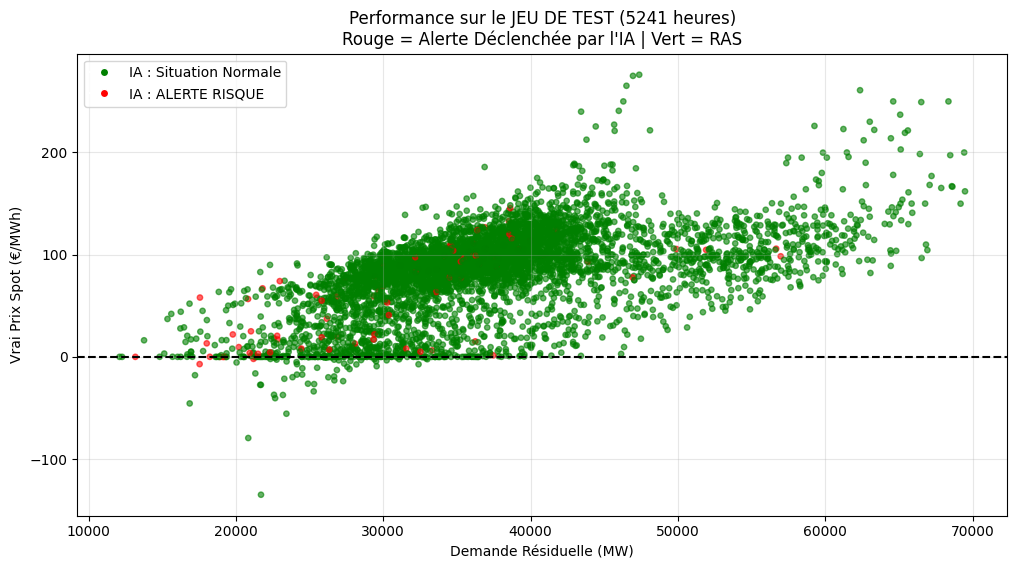

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from entsoe import EntsoePandasClient




# A. Les Fondamentaux (Pour le Modèle)
# Charge (Conso)
load = client.query_load_forecast(country_code, start=start_date, end=end_date)


# EnR (Vent + Solaire)
Prev = client.query_wind_and_solar_forecast(country_code, start=start_date, end=end_date, psr_type=None)
Prev['EnR'] = Prev.sum(axis=1) # Somme de toutes les colonnes (Wind Onshore/Offshore + Solar)

# B. La Vérité Terrain (Pour la Vérification uniquement)
# On récupère les PRIX pour voir si l'algo a raison
prices = client.query_day_ahead_prices(country_code, start=start_date, end=end_date)
prices = prices.to_frame('Price')

# Fusion
df = pd.concat([load, Prev['EnR'], prices], axis=1).dropna()


df['Residual_Load'] = df['Forecasted Load'] - df['EnR']

# 2. Le Gradient Brut (Variation d'une heure à l'autre)
df['Gradient'] = df['Residual_Load'].diff().fillna(0)

df['Hour'] = df.index.hour

# --- C'EST ICI QUE TU AJOUTES TON INTELLIGENCE ---

# Feature A : La "Chute" (Negative Ramp)
# On ne garde que les valeurs négatives. Les positives deviennent 0.
# Cela force l'Isolation Forest à ignorer les montées brusques de demande.
df['Crash_Factor'] = df['Gradient'].clip(upper=0) 

# Feature B : L'Accélération du Crash (Dérivée seconde optionnelle)
# Est-ce que ça chute de plus en plus vite ? 
# (Utile pour détecter le début du toboggan solaire à 11h du matin)
df['Acceleration'] = df['Gradient'].diff().fillna(0).clip(upper=0)

# Feature C : Le "Cocktail Molotov" (Charge Basse + Chute)
# Les prix négatifs arrivent quand la charge est DÉJÀ basse ET qu'elle continue de chuter.
# On crée une interaction mathématique pour accentuer ça.
# On inverse la charge (1/Charge) pour que "Petite Charge" devienne "Grand Chiffre".
# Et on multiplie par le crash (en valeur absolue).
# Plus ce score est haut, plus on est dans le mur.

df['Danger_Index'] = (1 / (df['Residual_Load'])) * df['Crash_Factor'].abs()

# Nettoyage des infinis éventuels
df.replace([np.inf, -np.inf], 0, inplace=True)

# On met à jour la liste des features pour l'entraînement
features = ['Residual_Load', 'Crash_Factor', 'Danger_Index', 'Hour']

# ==========================================
# 3. TRAIN / TEST SPLIT (TEMPOREL)
# ==========================================
# On garde les 20% les plus récents pour le TEST
split_index = int(len(df) * 0.4)

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()


# Préparation des matrices X (Features)
scaler = StandardScaler()

# On "fit" le scaler uniquement sur le train pour ne pas tricher
X_train = scaler.fit_transform(train_df[features])
X_test = scaler.transform(test_df[features]) # On applique la même transformation


# contamination=0.01 : On estime que 1% des heures sont "anormales" (Prix négatifs ou très bas)
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42, n_jobs=-1)
model.fit(X_train)

# ==========================================
# 5. ÉVALUATION SUR LE TEST
# ==========================================
# Le modèle prédit : -1 (Anomalie) ou 1 (Normal)
test_df['Prediction_Code'] = model.predict(X_test)
test_df['Anomaly_Detected'] = test_df['Prediction_Code'] == -1

# DÉFINITION DE LA RÉALITÉ (GROUND TRUTH)
# On considère qu'un "Succès" est la détection d'un prix < 0 € (ou très bas, ex < 10€)
test_df['Real_Negative_Price'] = test_df['Price'] < 0

print("\n--- RÉSULTATS DU BACKTEST ---")
print("Sur le jeu de test (données jamais vues) :")

# On croise la prédiction avec la réalité
true_positives = test_df[(test_df['Anomaly_Detected'] == True) & (test_df['Real_Negative_Price'] == True)]
false_positives = test_df[(test_df['Anomaly_Detected'] == True) & (test_df['Real_Negative_Price'] == False)]

print(f"Prix Négatifs correctement anticipés : {len(true_positives)}")
print(f"Fausses Alarmes (Modèle dit 'Danger' mais prix positif) : {len(false_positives)}")

# Prix moyen quand le modèle crie "ALERTE"
avg_price_alert = test_df[test_df['Anomaly_Detected'] == True]['Price'].mean()
print(f"Prix moyen lors des alertes : {avg_price_alert:.2f} €/MWh")

# ==========================================
# 6. VISUALISATION FINALE
# ==========================================
plt.figure(figsize=(12, 6))

# On affiche tout le Test Set
plt.scatter(test_df['Residual_Load'], test_df['Price'], 
            c=np.where(test_df['Anomaly_Detected'], 'red', 'green'), 
            alpha=0.6, s=15)

plt.axhline(0, color='black', linestyle='--')
plt.title(f"Performance sur le JEU DE TEST ({len(test_df)} heures)\nRouge = Alerte Déclenchée par l'IA | Vert = RAS")
plt.xlabel("Demande Résiduelle (MW)")
plt.ylabel("Vrai Prix Spot (€/MWh)")

# Légende manuelle
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='IA : Situation Normale'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='IA : ALERTE RISQUE')]
plt.legend(handles=legend_elements)

plt.grid(True, alpha=0.3)
plt.show()

Random Forest tentative 1

In [27]:
from sklearn.ensemble import RandomForestClassifier

# A. Les Fondamentaux (Pour le Modèle)
# Charge (Conso)
load = client.query_load_forecast(country_code, start=start_date, end=end_date)


# EnR (Vent + Solaire)
Prev = client.query_wind_and_solar_forecast(country_code, start=start_date, end=end_date, psr_type=None)
Prev['EnR'] = Prev.sum(axis=1) # Somme de toutes les colonnes (Wind Onshore/Offshore + Solar)

# B. La Vérité Terrain (Pour la Vérification uniquement)
# On récupère les PRIX pour voir si l'algo a raison
prices = client.query_day_ahead_prices(country_code, start=start_date, end=end_date)
prices = prices.to_frame('Price')

# Fusion
df = pd.concat([load, Prev['EnR'], prices], axis=1).dropna()
df['Residual_Load'] = df['Forecasted Load'] - df['EnR']
df['Gradient'] = df['Residual_Load'].diff().fillna(0)

df['Hour'] = df.index.hour


# ==========================================
# C. PRÉPARATION DE LA CIBLE (TARGET)
# ==========================================
# C'est ICI qu'on dit au modèle ce qu'il doit apprendre !
# 1 = DANGER (Prix Négatif), 0 = RAS
df['Target'] = (df['Price'] < 0).astype(int)

# On vérifie si on a assez de cas pour apprendre
print(f"Nombre d'heures à prix négatifs dans le dataset : {df['Target'].sum()}")

# ==========================================
# D. TRAIN / TEST SPLIT
# ==========================================
split_index = int(len(df) * 0.7) # On entraine sur 70% (Passé), on teste sur 30% (Futur)

train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

features = ['Residual_Load', 'Gradient', 'Hour']
X_train = scaler.fit_transform(train_df[features])
y_train = train_df['Target'] # <--- VOILÀ LA CLÉ ! On donne la réponse au modèle.

X_test = scaler.transform(test_df[features])
y_test = test_df['Target']

# ==========================================
# E. ENTRAINEMENT SUPERVISÉ
# ==========================================
print("🧠 Entraînement du Random Forest (Il apprend la relation Physique -> Prix)...")
# class_weight='balanced' est vital car les prix négatifs sont rares
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# C'est ici que la magie opère : on lui donne X (Physique) ET y (Prix)
model.fit(X_train, y_train)

# ==========================================
# F. PRÉDICTION
# ==========================================
test_df['Prediction_Code'] = model.predict(X_test)
# Proba de risque (entre 0 et 1)
test_df['Risk_Probability'] = model.predict_proba(X_test)[:, 1] 

# ==========================================
# G. RÉSULTATS
# ==========================================
# On regarde les résultats
true_positives = test_df[(test_df['Prediction_Code'] == 1) & (test_df['Target'] == 1)]
print(f"✅ Prix Négatifs correctement anticipés : {len(true_positives)}")

# Feature Importance (Pour ton entretien)
importances = pd.Series(model.feature_importances_, index=features)
print("\nCe qui cause les prix négatifs selon le modèle :")
print(importances.sort_values(ascending=False))

Nombre d'heures à prix négatifs dans le dataset : 147
🧠 Entraînement du Random Forest (Il apprend la relation Physique -> Prix)...
✅ Prix Négatifs correctement anticipés : 4

Ce qui cause les prix négatifs selon le modèle :
Residual_Load    0.707230
Gradient         0.156920
Hour             0.135849
dtype: float64


RF 2 :

In [28]:
from sklearn.metrics import precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

# A. Les Fondamentaux (Pour le Modèle)
# Charge (Conso)
load = client.query_load_forecast(country_code, start=start_date, end=end_date)


# EnR (Vent + Solaire)
Prev = client.query_wind_and_solar_forecast(country_code, start=start_date, end=end_date, psr_type=None)
Prev['EnR'] = Prev.sum(axis=1) # Somme de toutes les colonnes (Wind Onshore/Offshore + Solar)

# B. La Vérité Terrain (Pour la Vérification uniquement)
# On récupère les PRIX pour voir si l'algo a raison
prices = client.query_day_ahead_prices(country_code, start=start_date, end=end_date)
prices = prices.to_frame('Price')

df['Residual_Load'] = df['Forecasted Load'] - df['EnR']
df['Gradient'] = df['Residual_Load'].diff().fillna(0)

# A. Le Facteur Temps (CRUCIAL)
# Les prix négatifs, c'est souvent le Dimanche après-midi
df['Is_Weekend'] = (df.index.dayofweek >= 5).astype(int)
df['Hour'] = df.index.hour

# B. Le Ratio de Pénétration EnR
# Si les EnR couvrent 80% de la conso, c'est la zone rouge
# (On ajoute 1 pour éviter la division par zéro)
df['EnR_Penetration'] = df['EnR'] / (df['Forecasted Load'])

features = ['Residual_Load', 'Gradient', 'Is_Weekend', 'EnR_Penetration', 'Hour']

# ==========================================
# C. PRÉPARATION DE LA CIBLE (TARGET)
# ==========================================
# C'est ICI qu'on dit au modèle ce qu'il doit apprendre !
# 1 = DANGER (Prix Négatif), 0 = RAS
df['Target'] = (df['Price'] < 0).astype(int)

# On vérifie si on a assez de cas pour apprendre
print(f"Nombre d'heures à prix négatifs dans le dataset : {df['Target'].sum()}")

#3. SPLIT & TRAIN
# ==========================================
split_index = int(len(df) * 0.7)
train_df = df.iloc[:split_index].copy()
test_df = df.iloc[split_index:].copy()

# On utilise "class_weight='balanced_subsample'" qui est plus agressif
# pour forcer le modèle à faire attention aux cas rares
model = RandomForestClassifier(n_estimators=200, 
                               max_depth=10, # On limite la profondeur pour éviter le par-cœur
                               class_weight='balanced_subsample', 
                               random_state=42, 
                               n_jobs=-1)

X_train = scaler.fit_transform(train_df[features])
y_train = train_df['Target']
model.fit(X_train, y_train)

# ==========================================
# 4. ÉVALUATION AVEC SEUIL ADAPTATIF
# ==========================================
X_test = scaler.transform(test_df[features])
# On récupère les probabilités brutes (ex: 0.12, 0.45, 0.01...)
probs = model.predict_proba(X_test)[:, 1]

# On cherche le meilleur seuil automatiquement
# On veut attraper le maximum de prix négatifs (Recall) sans trop de fausses alertes (Precision)
precision, recall, thresholds = precision_recall_curve(test_df['Target'], probs)

# On prend un seuil manuel prudent pour commencer (ex: 20%)
seuil = 0.50
preds = (probs > seuil).astype(int)

# Résultats
tp = ((preds == 1) & (test_df['Target'] == 1)).sum()
fp = ((preds == 1) & (test_df['Target'] == 0)).sum()
real_neg = test_df['Target'].sum()

print(f"\n--- RÉSULTATS OPTIMISÉS (Seuil {seuil*100}%) ---")
print(f"🎯 Prix Négatifs Réels dans le test : {real_neg}")
print(f"✅ Détectés par le modèle (Vrais Positifs) : {tp}  (Soit {tp/real_neg:.1%} de réussite)")
print(f"⚠️ Fausses Alertes (Faux Positifs) : {fp}")

# Feature Importance
print("\n🔍 Ce qui compte vraiment :")
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print(importances)

Nombre d'heures à prix négatifs dans le dataset : 147

--- RÉSULTATS OPTIMISÉS (Seuil 50.0%) ---
🎯 Prix Négatifs Réels dans le test : 47
✅ Détectés par le modèle (Vrais Positifs) : 6  (Soit 12.8% de réussite)
⚠️ Fausses Alertes (Faux Positifs) : 85

🔍 Ce qui compte vraiment :
Residual_Load      0.522362
EnR_Penetration    0.265809
Is_Weekend         0.128057
Hour               0.045961
Gradient           0.037811
dtype: float64


In [5]:
client.query_load_forecast(country_code, start=start_date, end=end_date)

,Forecasted Load
2020-01-01 00:00:00+01:00,67300.0
2020-01-01 01:00:00+01:00,65200.0
2020-01-01 02:00:00+01:00,64700.0
2020-01-01 03:00:00+01:00,61250.0
2020-01-01 04:00:00+01:00,58650.0
...,...
2025-12-31 22:45:00+01:00,67700.0
2025-12-31 23:00:00+01:00,68500.0
2025-12-31 23:15:00+01:00,68700.0
2025-12-31 23:30:00+01:00,68900.0
